# Import Data

In [17]:
# helper.py
from helper import *
gc.collect()

1069

In [91]:
# load data
df = pd.read_csv('./data/clean/fantasy_data.csv')

# ensure values are sorted properly
df = df.sort_values(by=['Key', 'Exp']).reset_index(drop=True)

# rename target col
df = df.rename(columns={'PPGTarget_half-ppr': 'target'})

# check a row
df.sample()

,Player,Tm,Pos,Age,G,GS,Pass_Cmp,Pass_Att,Pass_Yds,Pass_TD,Pass_Int,Rush_Att,Rush_Yds,Rush_Y/A,Rush_TD,Rec_Tgt,Rec_Rec,Rec_Yds,Rec_Y/R,Rec_TD,Fmb,FmbLost,Scrim_TD,Key,Year,Pass_Y/A,Scrim_Yds,num_games,games_played_pct,games_started_pct,ProBowl,AllPro,Exp,Touches,Pass_Cmp%,Rec_Catch%,Pass_Cmp_per_game,Pass_Att_per_game,Pass_Yds_per_game,Pass_TD_per_game,Pass_Int_per_game,Rush_Att_per_game,Rush_Yds_per_game,Rush_TD_per_game,Rec_Tgt_per_game,Rec_Rec_per_game,Rec_Yds_per_game,Rec_TD_per_game,Fmb_per_game,FmbLost_per_game,Scrim_TD_per_game,Scrim_Yds_per_game,Touches_per_game,Points_half-ppr,PPG_half-ppr,PPT_half-ppr,PointsOvrRank_half-ppr,PointsPosRank_half-ppr,PPGOvrRank_half-ppr,PPGPosRank_half-ppr,PPTOvrRank_half-ppr,PPTPosRank_half-ppr,Points_VORP_half-ppr,PPG_VORP_half-ppr,PointsTarget_half-ppr,target
18729,Rob Moore,NYJ,WR,25,13,13,0,0,0,0,0,1,-6,-6.0,0,101.0,64,843,13.171875,1,2.0,1.1,1,MoorRo00,1993,0.0,837,16,0.8125,1.0,0,0,3,65,0.0,0.633663,0.0,0.0,0.0,0.0,0.0,0.076923,-0.461538,0.0,7.769231,4.923077,64.846154,0.076923,0.153846,0.084615,0.076923,64.384615,5.0,119.5,9.192308,1.838462,91,36,79,25,142,104,-6.94,0.517308,175.7,10.98125


# Stacking
Is their a correlation between positional fantasy points on the same team?

In [92]:
# drop rows with '2TM', '3TM', '4TM' values
df = df[~df['Tm'].isin(['2TM', '3TM', '4TM'])].reset_index(drop=True)

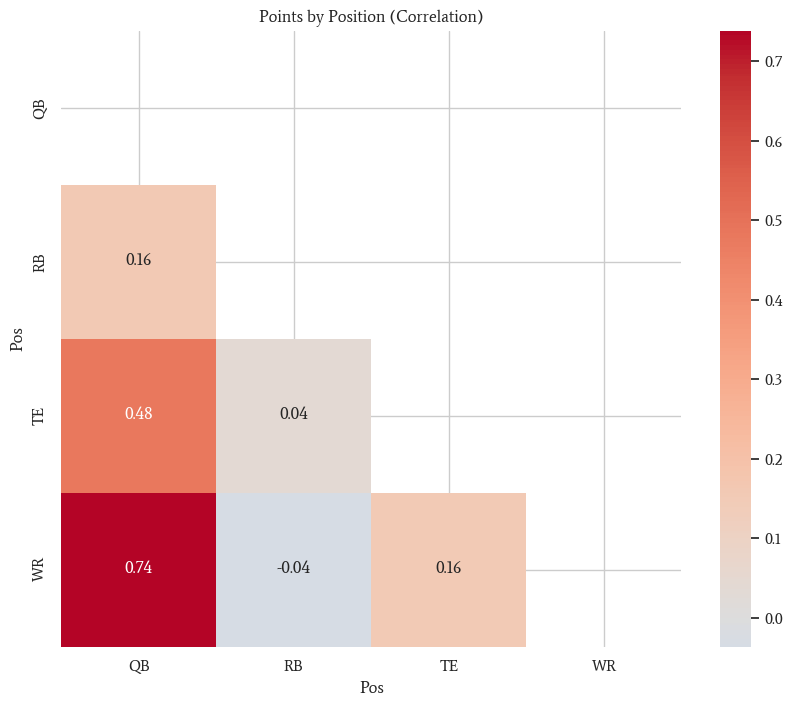

In [96]:
# calculate total points for each (Tm, Pos) combo
pos_points = df.groupby(['Tm', 'Year', 'Pos'])['Points_half-ppr'].sum().reset_index()

# for each (Tm, Year) group, calculate the percentage of points for each position
pos_points['Points_half-ppr_pct'] = pos_points['Points_half-ppr'] / pos_points.groupby(['Tm', 'Year'])['Points_half-ppr'].transform('sum')

# Pivot the data to create columns for each position's points
pivot = pos_points.pivot_table(index=['Tm', 'Year'], columns='Pos', values='Points_half-ppr')

# Compute the correlation between positions for each team and year
correlations = pivot.corr()

# only keep the lower triangle of the correlation matrix
mask = np.triu(np.ones_like(correlations, dtype=bool))
correlations = correlations.mask(mask)

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Points by Position (Correlation)")
plt.show()

- RBs correlate very little with other positions.
- WR performance has a strong correlation with QB production, while TE correlation is moderate.

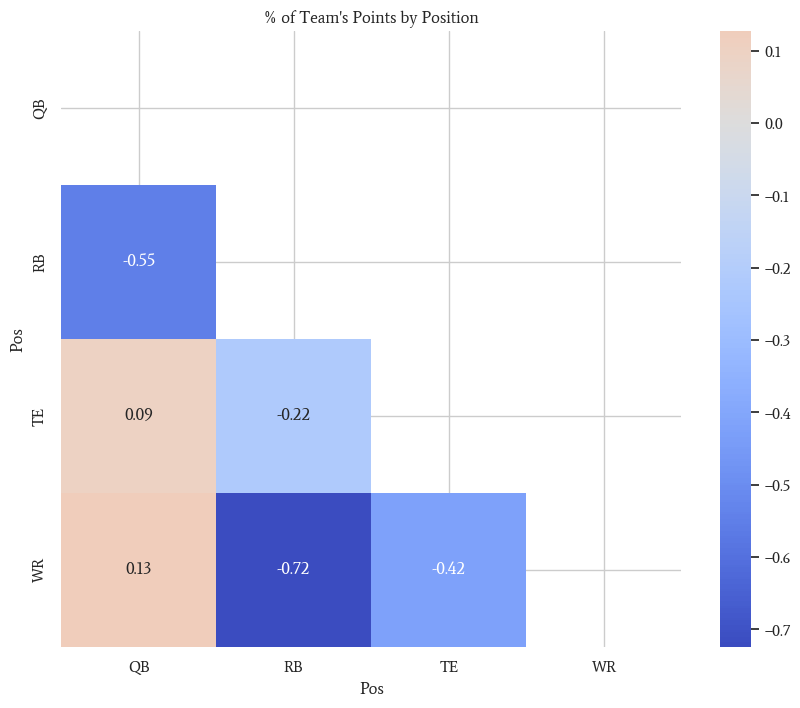

In [ ]:
# Pivot the data to create columns for each position's points percentage
pivot_pct = pos_points.pivot_table(index=['Tm', 'Year'], columns='Pos', values='Points_half-ppr_pct')

# Compute the correlation between positions for each team and year
correlations = pivot_pct.corr()

# only keep the lower triangle of the correlation matrix
mask = np.triu(np.ones_like(correlations, dtype=bool))
correlations = correlations.mask(mask)

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("% of Team's Points by Position (Correlation)")
plt.show()

- RB team production has a strong negative corr with WRs, a moderate negative corr with QBs, and a weak negative corr with TEs.
- WR team production has a moderate negative corr with TEs.

# Team Consistency

In [106]:
# sum points for each (Tm, Year) group in pos_points
team_points = pos_points.groupby(['Tm', 'Year'])['Points_half-ppr'].sum().reset_index().sort_values(['Tm','Year'])

def yoy_corr(grp):
    # grp is one team’s rows, sorted by Year
    # compute correlation between this year’s pts and last year’s pts
    # if there’s only one season, result will be NaN
    return grp['Points_half-ppr'].corr(grp['Points_half-ppr'].shift(1))

# apply per team
corr_df = (
    team_points
    .groupby('Tm')
    .apply(yoy_corr, include_groups=False)
    .reset_index(name='points_yoy_corr')
).dropna()

corr_df.points_yoy_corr.mean()

0.4840665080414956

In [107]:
# top teams of 2024
team_points.query('Year == 2024').sort_values(by='Points_half-ppr', ascending=False).T

,541,128,1553,324,1636,184,596,1215,1465,904,85,1410,30,789,486,780,849,772,687,431,646,1276,717,269,959,794,1581,1123,214,376,1068,1013
Tm,DET,BAL,TAM,CIN,WAS,BUF,GNB,PHI,SFO,MIN,ATL,SEA,ARI,LAR,DEN,LAC,MIA,KAN,IND,DAL,HOU,PIT,JAX,CHI,NOR,LVR,TEN,NYJ,CAR,CLE,NYG,NWE
Year,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024
Points_half-ppr,1645.04,1581.26,1563.6,1516.72,1405.28,1365.52,1348.06,1342.18,1304.26,1296.66,1294.52,1265.86,1261.36,1224.44,1223.7,1216.42,1205.92,1184.54,1162.46,1161.72,1158.18,1124.58,1098.18,1090.78,1089.1,1082.62,1068.14,1056.24,1048.94,1044.26,1040.42,1021.82


# QB grade corr with WR